In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from itertools import cycle
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from scipy import interp
import matplotlib.pyplot as plt
from engarde.decorators import has_dtypes
from capstone_project import preprocessor

#from IPython.display import display
%matplotlib inline

In [2]:
# Make sure that the loaded dataframe has the correct layout otherwise throw assertion error 
@has_dtypes(dict(question1=object, question2=object, is_duplicate=int, q1_tokens=object, q2_tokens=object, 
                q1_vecsum=object, q2_vecsum=object))
def load_data(file_dir, filename):
    """Load dataframe using filename as input. A pandas dataframe is returned and it is checked that it 
    has the correct layout.
    """
    df = pd.read_pickle(file_dir+filename)
    return df

def save_pickle(dataset, output_dir, filename):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    with open (output_dir+filename, "wb") as handle:
        pickle.dump(dataset, handle)

def load_pickle(input_dir, filename):
    with open (input_dir+filename, "rb") as handle:
        return pickle.load(handle)

In [3]:
# The current working directory for python is the capstone_project/notebook folder
file_directory = "../output/data/"
prefix = ""

train_data = load_data(file_directory, prefix+"preprocessed_train_data.pkl")

In [4]:
model_directory = "../output/models/"
skf = load_pickle(model_directory, "kfolds.pkl") 

In [5]:
tfidf = preprocessor.TfidfTransformer()
feature_engineering = preprocessor.FeatureTransformer()

y = train_data["is_duplicate"].values

mms = MinMaxScaler()
#train_features = mms.fit_transform(feature_df)

feature_creator = FeatureUnion([('feature_engineering', feature_engineering), ('tfidf', tfidf)])
clf = LogisticRegression()


#pipe = Pipeline([("features", feature_creator), ("logistic", clf)])
pipe = Pipeline([("features", feature_engineering), ("scaling", mms), ("logistic", clf)])

print pipe.get_params().keys()

['logistic__max_iter', 'logistic__verbose', 'features', 'logistic__solver', 'logistic__tol', 'scaling__feature_range', 'logistic__dual', 'logistic__fit_intercept', 'logistic__warm_start', 'scaling', 'scaling__copy', 'steps', 'logistic__multi_class', 'logistic', 'logistic__class_weight', 'logistic__C', 'logistic__random_state', 'logistic__penalty', 'logistic__intercept_scaling', 'logistic__n_jobs']


In [6]:
#http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [7]:
from scipy.stats import uniform
from time import time


#print cross_val_score(pipe, X, y, scoring="neg_log_loss", cv=skf)
#print cross_val_score(pipe, X, y, scoring="accuracy", cv=skf)

param_dist = {"logistic__C": uniform(3, 8)}
n_iter_search = 20
random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=n_iter_search, cv=skf, scoring="neg_log_loss")
              
start = time()
random_search.fit(train_data, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)  

#for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    #X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    #y_train, y_test = y[train_index], y[test_index]

ValueError: ('shapes (300,) and (1,) not aligned: 300 (dim 0) != 1 (dim 0)', u'occurred at index 60391')

In [65]:
prefix = "second_test_"

save_pickle(random_search, model_directory, prefix+"logistic_search.pkl") 
save_pickle(pipe, model_directory, prefix+"logistic_pipeline.pkl") 

In [69]:
prefix = "first_test_"

random_search = load_pickle(model_directory, prefix+"logistic_search.pkl")
pipe = load_pickle(model_directory, prefix+"logistic_pipeline.pkl")

ROC fold 0 accuracy: 0.6733
ROC fold 1 accuracy: 0.6737
ROC fold 2 accuracy: 0.6716
Mean accuracy: 0.6729 (std: 0.0009)


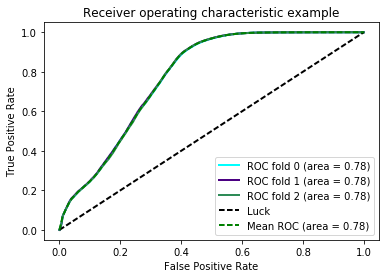

In [72]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html



best_pipe = random_search.best_estimator_

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen'])
lw = 2

accs = []
i = 0
for (train_index, test_index), color in zip(skf.split(train_data, y), colors):
    pred = best_pipe.predict_proba(train_data.iloc[test_index])
    fpr, tpr, thresholds = roc_curve(y[test_index], pred[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    
    acc = best_pipe.score(train_data.iloc[test_index], y[test_index])
    accs.append(acc)
    print "ROC fold {} accuracy: {:.4f}".format(i, acc)
    i += 1
    
print "Mean accuracy: {:.4f} (std: {:.4f})".format(np.mean(accs), np.std(accs))
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= skf.get_n_splits(train_data, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()